In [1]:
!pip install --upgrade numpy==1.23.5 mediapipe networkx kagglehub opencv-contrib-python==4.8.0.76

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 29.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
 

## ASL Diffusion Generation

In [1]:
# ─── Standard Libraries ──────────────────────────────────────────────
import os
import re
import glob
import json
import uuid
import copy
import shutil
import tempfile
import random
from collections import defaultdict
from functools import lru_cache

# ─── Numerical & Data Processing ─────────────────────────────────────
import numpy as np
import multiprocessing as mp_local
import gc
import media

# ─── Visualization ───────────────────────────────────────────────────
import matplotlib.pyplot as plt
from PIL import Image

# ─── CV & Media ──────────────────────────────────────────────────────
import cv2
from cv2 import ximgproc

# ─── Progress & File Handling ────────────────────────────────────────
from tqdm.auto import tqdm
from google.colab import drive, files

# ─── PyTorch ─────────────────────────────────────────────────────────
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from torchvision import transforms
from torchvision.utils import save_image

# ─── HuggingFace & Diffusers ─────────────────────────────────────────
from transformers import (
    CLIPTokenizer, CLIPTextModel, CLIPFeatureExtractor
)
from diffusers import (
    StableDiffusionPipeline, StableDiffusionControlNetPipeline,
    StableDiffusionImg2ImgPipeline, UNet2DConditionModel,
    AutoencoderKL, DDPMScheduler, ControlNetModel
)

# ─── LoRA & Acceleration ─────────────────────────────────────────────
from peft import (
    LoraConfig, get_peft_model,
    prepare_model_for_kbit_training, PeftModel
)
from accelerate import Accelerator

# ─── External Utilities ──────────────────────────────────────────────
import kagglehub
import networkx as nx
import mediapipe as mp
from sklearn.neighbors import NearestNeighbors

# ─── Device Configuration ────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", device)


Using cuda


In [2]:
os.environ["KAGGLE_USERNAME"] = "ashtik"
os.environ["KAGGLE_KEY"]      = "20bc49d76d85ce8dcbce92690201bafb"

DATASET_DIR = "/content/wlasl-processed"
VIDEOS_DIR  = os.path.join(DATASET_DIR, "videos")
JSON_PATH   = os.path.join(DATASET_DIR, "WLASL_v0.3.json")
POSE_DIR    = "/content/drive/MyDrive/wlasl_skeletons"

src = kagglehub.dataset_download("risangbaskoro/wlasl-processed")
shutil.rmtree(DATASET_DIR, ignore_errors=True)
shutil.copytree(src, DATASET_DIR)
print("Dataset copied to", DATASET_DIR)


Dataset copied to /content/wlasl-processed


In [16]:
shutil.rmtree(POSE_DIR, ignore_errors=True)

In [4]:
# 1. Load the metadata
with open(JSON_PATH, "r") as f:
    video_info = json.load(f)

# 2. Extract all unique glosses (replace "_" with space)
all_glosses = sorted({entry["gloss"].replace("_", " ") for entry in video_info})

# 3. Print count and list
print(f"Found {len(all_glosses)} unique glosses:")
print(all_glosses)

Found 2000 unique glosses:
['a', 'a lot', 'abdomen', 'able', 'about', 'above', 'accent', 'accept', 'accident', 'accomplish', 'accountant', 'across', 'act', 'action', 'active', 'activity', 'actor', 'adapt', 'add', 'address', 'adjective', 'adjust', 'admire', 'admit', 'adopt', 'adult', 'advanced', 'advantage', 'adverb', 'affect', 'afraid', 'africa', 'after', 'afternoon', 'again', 'against', 'age', 'agenda', 'ago', 'agree', 'agreement', 'ahead', 'aid', 'aim', 'airplane', 'alarm', 'alcohol', 'algebra', 'all', 'all day', 'allergy', 'alligator', 'allow', 'almost', 'alone', 'alphabet', 'already', 'also', 'always', 'amazing', 'america', 'amputate', 'analyze', 'anatomy', 'and', 'angel', 'angle', 'angry', 'animal', 'anniversary', 'announce', 'annoy', 'another', 'answer', 'any', 'anyway', 'apart', 'apartment', 'apostrophe', 'appear', 'appetite', 'apple', 'appointment', 'appreciate', 'approach', 'appropriate', 'approve', 'april', 'archery', 'area', 'argue', 'arizona', 'arm', 'army', 'around', 'arre

In [17]:
WORDS = [
    "hello",
    "please",
    "thank you",
    "yes",
    "no",
    "good",
    "bad",
    "sorry",
    "love",
    "stop",
]
os.makedirs(POSE_DIR, exist_ok=True)
with open(JSON_PATH) as f:
    video_info = json.load(f)

FRAMES_PER_VIDEO = 100
OUTPUT_SIZE = (512, 512)

mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    static_image_mode=True,
    model_complexity=2,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7,
)

BODY_LS = mp.solutions.drawing_utils.DrawingSpec(
    color=(255, 0, 0),  # pure blue lines
    thickness=4,
    circle_radius=0,  # no joint circles
)
BODY_CS = mp.solutions.drawing_utils.DrawingSpec(
    color=(255, 0, 0), thickness=4, circle_radius=0  # pure blue lines
)

FINGER_CONNECTIONS = {
    "thumb": [(0, 1), (1, 2), (2, 3), (3, 4)],
    "index": [(0, 5), (5, 6), (6, 7), (7, 8)],
    "middle": [(0, 9), (9, 10), (10, 11), (11, 12)],
    "ring": [(0, 13), (13, 14), (14, 15), (15, 16)],
    "pinky": [(0, 17), (17, 18), (18, 19), (19, 20)],
}
FINGER_COLORS = {
    "thumb": (255, 165, 0),
    "index": (0, 255, 0),
    "middle": (0, 255, 255),
    "ring": (255, 0, 255),
    "pinky": (128, 0, 255),
}


In [7]:
def pose_to_openpose(png_path, out_png="wire.png"):
    img = cv2.imread(png_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, bw = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    ys, xs = np.where(bw)
    pts = np.column_stack([xs, ys])
    if len(pts) < 20:
        raise ValueError("few keypoints")

    g = nx.Graph()
    for i, p in enumerate(pts):
        g.add_node(i, xy=p)
    nbrs = NearestNeighbors(n_neighbors=5).fit(pts)
    for i, neigh in enumerate(nbrs.kneighbors(pts, return_distance=False)):
        for j in neigh[1:]:
            g.add_edge(i, j)
    wire = np.zeros_like(img)
    for i, j in g.edges():
        p1, p2 = tuple(pts[i]), tuple(pts[j])
        cv2.line(wire, p1, p2, (255, 255, 255), 3)
    cv2.imwrite(out_png, wire)
    return out_png


## ASL Skeleton Extraction Pipeline

This pipeline processes American Sign Language (ASL) videos to generate standardized skeleton images highlighting body and finger landmarks.

---

### **1. Setup and Constants**

- **Paths:**
  - `DATASET_DIR`: Path to the processed WLASL dataset.
  - `VIDEOS_DIR`: Path to the directory containing ASL videos.
  - `JSON_PATH`: Path to the JSON metadata file.
  - `POSE_DIR`: Output directory for skeleton images on Google Drive.

- **Constants:**
  - `FRAMES_PER_VIDEO`: Number of frames extracted per video (set to 30).
  - `OUTPUT_SIZE`: Size of the output skeleton images (512×512 pixels).
  - `LINE_THICK`: Thickness of the skeleton lines.

- **Finger Connections & Colors:**
  Defines the landmark connections and corresponding colors for fingers.

---

### **2. Load Metadata & Glosses**

- Loads video metadata from `WLASL_v0.3.json`.
- Builds a list (`all_glosses`) containing unique ASL glosses to process.

---

### **3. Utility Function (`center_and_pad`)**

- Crops skeleton images tightly around landmarks.
- Centers and resizes the cropped skeleton onto a standardized black canvas of 512×512 pixels.

---

### **4. Worker Initialization & Task Function**

- **`init_worker()`**: Initializes the Mediapipe Holistic model for each worker process.
- **`process_task()`**: Processes individual `(gloss, instance)` pairs:
  - Extracts evenly spaced frames from each video.
  - Detects body and hand landmarks using Mediapipe.
  - Draws body and finger skeletons on separate masks.
  - Applies thinning and dilation to clearly visualize skeletal structures.
  - Combines skeleton masks and saves standardized images.

---

### **5. Parallel Processing**

- **`extract_skeletons_parallel()`**: Distributes tasks across all CPU cores for efficient parallel processing using Python’s multiprocessing.
- Tasks involve extracting and saving standardized skeleton images for each ASL gloss.

---

### **6. Execution**

- Checks if skeleton images already exist in the specified Google Drive directory (`POSE_DIR`).
- If not, runs parallel skeleton extraction for the specified glosses.

Skeleton images are saved as PNG files in your Google Drive directory.

---


In [18]:
# ── 1) Mount Drive ─────────────────────────────────────────────
# drive.mount('/content/drive')

# ── 2) Paths & Constants ───────────────────────────────────────
DATASET_DIR = "/content/wlasl-processed"
VIDEOS_DIR = os.path.join(DATASET_DIR, "videos")
JSON_PATH = os.path.join(DATASET_DIR, "WLASL_v0.3.json")
POSE_DIR = "/content/drive/MyDrive/wlasl_skeletons"

FRAMES_PER_VIDEO = 30
OUTPUT_SIZE = (512, 512)
LINE_THICK = 3

FINGER_CONNECTIONS = {
    "thumb": [(0, 1), (1, 2), (2, 3), (3, 4)],
    "index": [(0, 5), (5, 6), (6, 7), (7, 8)],
    "middle": [(0, 9), (9, 10), (10, 11), (11, 12)],
    "ring": [(0, 13), (13, 14), (14, 15), (15, 16)],
    "pinky": [(0, 17), (17, 18), (18, 19), (19, 20)],
}
FINGER_COLORS = {
    "thumb": (255, 165, 0),
    "index": (0, 255, 0),
    "middle": (0, 255, 255),
    "ring": (255, 0, 255),
    "pinky": (128, 0, 255),
}

# ── 3) Load metadata & build gloss list ────────────────────────
with open(JSON_PATH, "r") as f:
    video_info = json.load(f)
all_glosses = sorted({v["gloss"].replace("_", " ") for v in video_info})
print(f"Will extract skeletons for {len(all_glosses)} glosses.")


# ── 4) Utility: center & pad ───────────────────────────────────
def center_and_pad(img, size=512):
    h, w = img.shape[:2]
    coords = cv2.findNonZero(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    x, y, bw, bh = cv2.boundingRect(coords)
    crop = img[y : y + bh, x : x + bw]
    scale = size / max(bw, bh)
    crop = cv2.resize(
        crop, (int(bw * scale), int(bh * scale)), interpolation=cv2.INTER_NEAREST
    )
    canvas = np.zeros((size, size, 3), dtype=np.uint8)
    ch, cw = crop.shape[:2]
    canvas[(size - ch) // 2 : (size + ch) // 2, (size - cw) // 2 : (size + cw) // 2] = (
        crop
    )
    return canvas


# ── 5) Worker setup & task fn ──────────────────────────────────
def init_worker():
    """Initialize per-process globals."""
    global hol
    hol = mp.solutions.holistic.Holistic(static_image_mode=True)


def process_task(args):
    """Process one (gloss, instance) pair."""
    gloss, inst = args
    vid_path = os.path.join(VIDEOS_DIR, f"{inst['video_id']}.mp4")
    if not os.path.exists(vid_path):
        return

    cap = cv2.VideoCapture(vid_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    sel = [round((i + 0.5) * total / FRAMES_PER_VIDEO) for i in range(FRAMES_PER_VIDEO)]

    for idx, fidx in enumerate(sel):
        cap.set(cv2.CAP_PROP_POS_FRAMES, fidx)
        ok, frame = cap.read()
        if not ok:
            continue

        res = hol.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if not res.pose_landmarks:
            continue

        h, w = frame.shape[:2]
        body_mask = np.zeros((h, w), np.uint8)
        finger_masks = {f: np.zeros_like(body_mask) for f in FINGER_COLORS}

        # draw skeleton edges
        for i1, i2 in mp.solutions.holistic.POSE_CONNECTIONS:
            p1 = res.pose_landmarks.landmark[i1]
            p2 = res.pose_landmarks.landmark[i2]
            cv2.line(
                body_mask,
                (int(p1.x * w), int(p1.y * h)),
                (int(p2.x * w), int(p2.y * h)),
                255,
                1,
            )

        # draw each finger
        for hand in (res.left_hand_landmarks, res.right_hand_landmarks):
            if not hand:
                continue
            lm = hand.landmark
            for finger, conns in FINGER_CONNECTIONS.items():
                m = finger_masks[finger]
                for i1, i2 in conns:
                    x1, y1 = int(lm[i1].x * w), int(lm[i1].y * h)
                    x2, y2 = int(lm[i2].x * w), int(lm[i2].y * h)
                    cv2.line(m, (x1, y1), (x2, y2), 255, 1)

        # thin + dilate
        bm = ximgproc.thinning(body_mask, ximgproc.THINNING_ZHANGSUEN)
        bm = cv2.dilate(
            bm,
            cv2.getStructuringElement(cv2.MORPH_RECT, (LINE_THICK, LINE_THICK)),
            iterations=1,
        )
        ske = np.zeros_like(frame)
        ske[:, :, 0][bm > 0] = 255

        for finger, mask in finger_masks.items():
            fm = ximgproc.thinning(mask, ximgproc.THINNING_ZHANGSUEN)
            fm = cv2.dilate(
                fm,
                cv2.getStructuringElement(cv2.MORPH_RECT, (LINE_THICK, LINE_THICK)),
                iterations=1,
            )
            b, g, r = FINGER_COLORS[finger]
            ske[:, :, 0][fm > 0] = b
            ske[:, :, 1][fm > 0] = g
            ske[:, :, 2][fm > 0] = r

        ske = center_and_pad(ske, OUTPUT_SIZE[0])
        out_path = os.path.join(POSE_DIR, f"{gloss}_{inst['video_id']}_{idx}.png")
        cv2.imwrite(out_path, ske)

    cap.release()


# ── 6) Parallel extractor ───────────────────────────────────────
def extract_skeletons_parallel(all_glosses=all_glosses):
    # build a map gloss → list of instances
    word_to_vids = {g: [] for g in all_glosses}
    for v in video_info:
        g = v["gloss"].replace("_", " ")
        if g in word_to_vids:
            word_to_vids[g].extend(v["instances"])

    # flatten to (gloss, instance) tasks
    tasks = [(gloss, inst) for gloss in all_glosses for inst in word_to_vids[gloss]]

    # use all CPU cores
    with mp_local.Pool(processes=mp_local.cpu_count(), initializer=init_worker) as pool:
        list(
            tqdm(
                pool.imap_unordered(process_task, tasks),
                total=len(tasks),
                desc="Extracting (parallel)",
            )
        )

    print("Skeleton PNGs saved to", POSE_DIR)


# ── 7) Run extraction (with caching) ───────────────────────────
os.makedirs(POSE_DIR, exist_ok=True)
if os.listdir(POSE_DIR):
    print("Skeletons already exist in Drive—skipping extraction.")
else:
    extract_skeletons_parallel(all_glosses=WORDS)


Will extract skeletons for 2000 glosses.


Extracting (parallel):   0%|          | 0/155 [00:00<?, ?it/s]

Skeleton PNGs saved to /content/drive/MyDrive/wlasl_skeletons


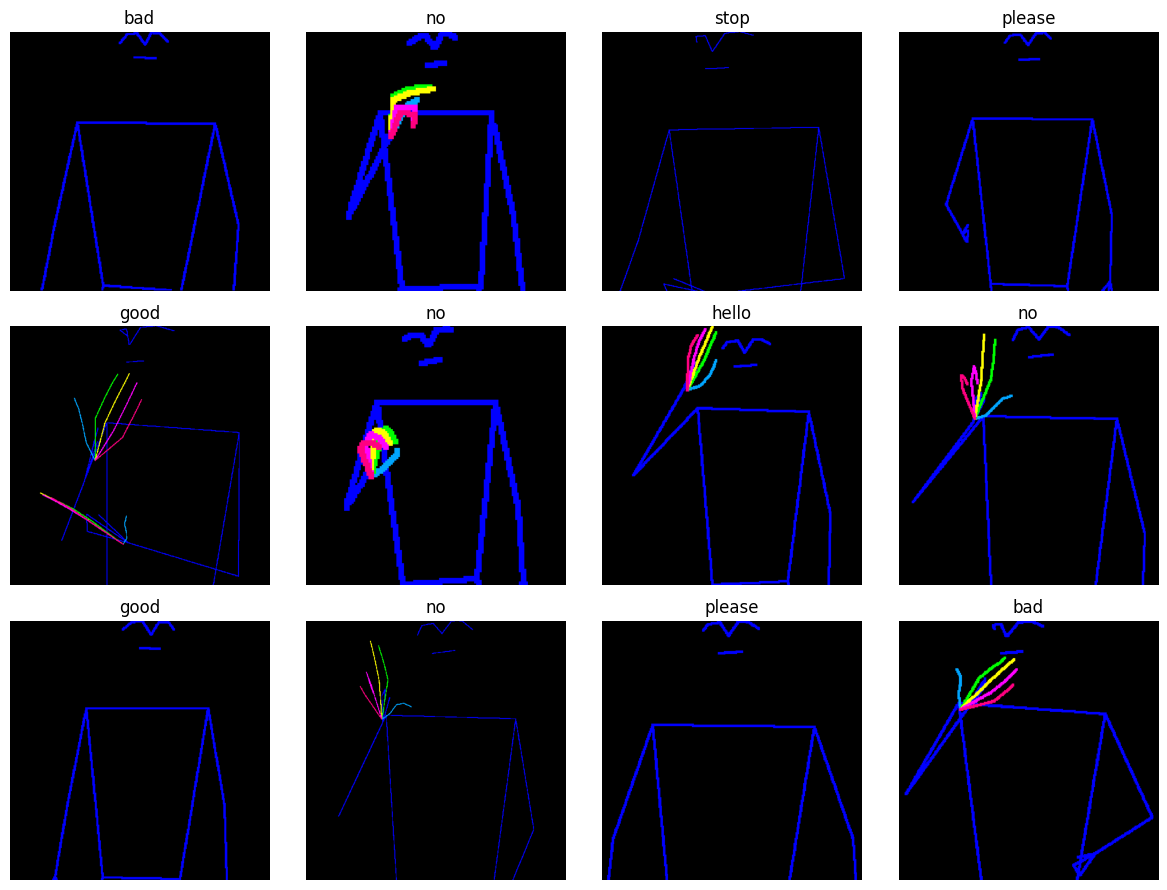

In [20]:
def show_skeleton_gallery(rows=3, cols=4):
    """
    Display a gallery of randomly‑selected skeleton PNGs.
    """
    paths = glob.glob(os.path.join(POSE_DIR, "*.png"))
    if not paths:
        print("No skeleton PNGs found in", POSE_DIR)
        return

    sample = random.sample(paths, min(rows * cols, len(paths)))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()

    for ax, p in zip(axes, sample):
        img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(os.path.basename(p).split("_")[0])
        ax.axis("off")

    for ax in axes[len(sample) :]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


show_skeleton_gallery(rows=3, cols=4)


### **1. Model Generation (`generate_one_from_model`)**

- Generates an ASL skeleton image for a specified word using a trained Stable Diffusion model.
- Sets up FP16 precision models (`UNet`, `TextEncoder`, `VAE`) for efficient inference.
- Constructs a custom prompt to guide diffusion generation specifically for ASL skeleton visualization.
- Outputs a tensor version of the generated image.

---

### **2. ASL Skeleton Dataset (`ASLSkeletonDataset`)**

- A PyTorch `Dataset` class that loads pre-processed skeleton PNG images labeled by ASL glosses.
- Images are resized to 512×512 pixels, normalized, and converted into tensors suitable for training.
- Each sample returns:
  - `pixel_values`: Normalized RGB tensor of the skeleton image.
  - `input_ids`: Tokenized representation of the gloss prompt using CLIP tokenizer.

---

### **3. Model Initialization (`initialize_models`)**

- Loads pre-trained components from Stable Diffusion (`CompVis/stable-diffusion-v1-4`):
  - CLIP tokenizer and text encoder (`openai/clip-vit-large-patch14`).
  - UNet diffusion model and VAE autoencoder for image encoding/decoding.
  - DDPM scheduler controlling noise timesteps.
- Configures a **LoRA** model (Low-Rank Adaptation) to fine-tune specific attention layers (`to_q`, `to_k`, `to_v`) within the UNet for efficient adaptation to the ASL skeleton dataset.
- Enables gradient checkpointing to reduce GPU memory usage during training.

---

### **4. Training Loop (`train_model`)**

- Parameters:
  - `epochs`: Number of training epochs.
  - `bs`: Batch size.
  - `lr`: Learning rate.
  - `val_split`: Fraction of dataset reserved for validation.
  - `resolution`: Image size for training.
  - `preview_word`: ASL gloss used to generate periodic preview images during training.
  - `accumulation_steps`: Gradient accumulation to effectively simulate larger batch sizes.

- Workflow:
  - Splits the dataset into training and validation sets.
  - Performs forward passes to encode images into latent spaces, adds scheduled noise, and predicts noise via the UNet.
  - Uses FP32 precision for stable training, with manual gradient clipping.
  - Implements gradient accumulation to handle limited GPU memory efficiently.
  - After each epoch, evaluates on the validation set, logs average losses, and generates a preview image.
  - Implements early stopping with a patience mechanism (stops if validation loss doesn't improve for 3 epochs or if validation loss significantly exceeds training loss).

- Saves the best-performing model checkpoint (LoRA-adapted UNet) based on validation loss.

---

### **5. Output**

- Trained LoRA-adapted Stable Diffusion model saved under:


In [19]:
def generate_one_from_model(
    word: str,
    model,
    tokenizer,
    text_encoder,
    vae,
    scheduler,
    resolution: int = 512,
    device: str = "cuda",
    seed: int = 42,
):
    fx = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-large-patch14")

    fp16_unet = copy.deepcopy(model).half()
    fp16_text_encoder = copy.deepcopy(text_encoder).half()
    fp16_vae = copy.deepcopy(vae).half()

    pipe = StableDiffusionPipeline(
        tokenizer=tokenizer,
        text_encoder=fp16_text_encoder,
        vae=fp16_vae,
        unet=fp16_unet,
        scheduler=scheduler,
        safety_checker=None,
        feature_extractor=fx,
        torch_dtype=torch.float16,
    ).to(device)

    pipe.enable_attention_slicing()

    prompt = (
        f"single person signing '{word}' in ASL with blue skeleton on black background"
    )
    generator = torch.Generator(device=device).manual_seed(seed)
    img = pipe(
        prompt,
        height=resolution,
        width=resolution,
        num_inference_steps=40,
        guidance_scale=8.0,
        generator=generator,
    ).images[0]

    return transforms.ToTensor()(img)


In [21]:
class ASLSkeletonDataset(Dataset):
    """
    Dataset of 512×512 skeleton images labeled by ASL gloss (word only).
    Each sample consists of an image and a tokenized gloss prompt.
    """

    def __init__(self, pose_dir, gloss_list, tokenizer, resolution=512):
        self.samples = []
        for gloss in gloss_list:
            paths = sorted(glob.glob(os.path.join(pose_dir, f"{gloss}_*.png")))
            self.samples.extend([(p, gloss) for p in paths])

        self.tokenizer = tokenizer
        self.transform = transforms.Compose(
            [
                transforms.Resize(
                    (resolution, resolution), interpolation=Image.NEAREST
                ),
                transforms.ToTensor(),
                transforms.Normalize([0.5] * 3, [0.5] * 3),
            ]
        )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, gloss = self.samples[idx]
        image = Image.open(path).convert("RGB")
        pixel_values = self.transform(image)

        # Use only the gloss itself as the prompt
        prompt = gloss
        input_ids = self.tokenizer(
            prompt,
            padding="max_length",
            truncation=True,
            max_length=77,
            return_tensors="pt",
        ).input_ids[0]

        return {"pixel_values": pixel_values, "input_ids": input_ids}


def initialize_models():
    tok = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
    te = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
    unet = UNet2DConditionModel.from_pretrained(
        "CompVis/stable-diffusion-v1-4", subfolder="unet"
    )
    vae = AutoencoderKL.from_pretrained(
        "CompVis/stable-diffusion-v1-4", subfolder="vae"
    )
    sched = DDPMScheduler.from_pretrained(
        "CompVis/stable-diffusion-v1-4", subfolder="scheduler"
    )
    lora_cfg = LoraConfig(
        r=64,
        lora_alpha=32,
        target_modules=["to_q", "to_k", "to_v"],
        lora_dropout=0.1,
        bias="none",
    )
    unet = prepare_model_for_kbit_training(unet, use_gradient_checkpointing=True)
    unet = get_peft_model(unet, lora_cfg)
    return tok, te, unet, vae, sched


In [28]:
import math
def train_model(
    epochs: int = 5,
    bs: int = 2,
    lr: float = 5e-5,
    val_split: float = 0.1,
    resolution: int = 512,
    preview_word: str = "hello",
    accumulation_steps: int = 2,
    all_glosses=None,
):
    """
    Pure PyTorch training loop in full FP32.
      - gradient_accumulation by `accumulation_steps`
      - manual clipping in FP32
      - early stopping & per-epoch previews
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs("./epoch_outputs", exist_ok=True)

    # Initialize & move to device
    tok, te, unet, vae, sched = initialize_models()
    te.to(device).eval()   # CLIPTextModel inference only
    vae.to(device).eval()  # VAE inference only
    unet.to(device).train() # UNet is trainable

    # Dataset + split
    ds = ASLSkeletonDataset(POSE_DIR, all_glosses, tok, resolution)
    n_train = int((1 - val_split) * len(ds))
    n_val = len(ds) - n_train
    train_ds, val_ds = torch.utils.data.random_split(ds, [n_train, n_val])
    train_dl = DataLoader(train_ds, bs, shuffle=True, pin_memory=True)
    val_dl = DataLoader(val_ds, bs, pin_memory=True)

    # Optimizer & scheduler
    optim = torch.optim.AdamW(unet.parameters(), lr=lr, weight_decay=1e-2)
    steps_per_epoch = max(1, math.ceil(len(train_dl) / accumulation_steps))
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optim,
        max_lr=lr,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        pct_start=0.1,
    )

    best_val_loss = float("inf")
    patience, max_patience = 0, 3

    for ep in range(1, epochs + 1):
        # — Training —
        unet.train()
        total_train_loss = 0.0
        optim.zero_grad()

        for step, batch in enumerate(tqdm(train_dl, desc=f"Train Ep{ep}")):
            pv = batch["pixel_values"].to(device)  # [B,3,512,512]
            ids = batch["input_ids"].to(device)    # [B,77]

            # forward
            with torch.no_grad():
                emb = te(ids)[0]
            lat = vae.encode(pv).latent_dist.sample() * vae.config.scaling_factor
            noise = torch.randn_like(lat)
            ts = torch.randint(0, sched.config.num_train_timesteps,
                               (lat.size(0),), device=device)
            noisy = sched.add_noise(lat, noise, ts)
            pred = unet(noisy, ts, encoder_hidden_states=emb).sample

            loss = torch.nn.functional.mse_loss(pred, noise, reduction="mean")
            (loss / accumulation_steps).backward()
            total_train_loss += loss.item()

            # gradient accumulation step
            if (step + 1) % accumulation_steps == 0 or (step + 1) == len(train_dl):
                clip_grad_norm_(unet.parameters(), max_norm=1.0)
                optim.step()
                optim.zero_grad()
                lr_scheduler.step()

        avg_train = total_train_loss / len(train_dl)

        # — Validation —
        unet.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(val_dl, desc=f"Val Ep{ep}"):
                pv = batch["pixel_values"].to(device)
                ids = batch["input_ids"].to(device)
                emb = te(ids)[0]
                lat = vae.encode(pv).latent_dist.sample() * vae.config.scaling_factor
                noise = torch.randn_like(lat)
                ts = torch.randint(0, sched.config.num_train_timesteps,
                                   (lat.size(0),), device=device)
                noisy = sched.add_noise(lat, noise, ts)
                pred = unet(noisy, ts, encoder_hidden_states=emb).sample
                total_val_loss += torch.nn.functional.mse_loss(pred, noise).item()

        avg_val = total_val_loss / len(val_dl)

        # — Preview & Checkpoint —
        try:
            out_img = generate_one_from_model(
                word=preview_word,
                model=unet,
                tokenizer=tok,
                text_encoder=te,
                vae=vae,
                scheduler=sched,
                resolution=resolution,
                device=device,
            )
            save_image(out_img, f"./epoch_outputs/epoch_{ep}_{preview_word}.png")
            print(f"Saved preview for '{preview_word}' at epoch {ep}")
        except Exception:
            pass

        print(f"Epoch {ep} | Train: {avg_train:.4f} | Val: {avg_val:.4f} | Pat: {patience}/{max_patience}")
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            patience = 0
            unet.save_pretrained("./asl_skeleton_lora_improved", safe_serialization=True)
            print(f"New best model saved at epoch {ep}")
        else:
            patience += 1
            if patience >= max_patience or avg_val > avg_train * 1.8:
                print("Stopping early.")
                break

    return unet, te, tok, vae, sched


In [ ]:

gc.collect()
torch.cuda.empty_cache()
trained_model = train_model(all_glosses=WORDS)

In [31]:
from collections import defaultdict

all_pngs = glob.glob(os.path.join(POSE_DIR, "*.png"))

GLOSS_TO_IMAGES = defaultdict(list)
for p in all_pngs:
    fname = os.path.basename(p)
    gloss = fname.split("_", 1)[0]
    GLOSS_TO_IMAGES[gloss].append(p)

for gloss in GLOSS_TO_IMAGES:
    GLOSS_TO_IMAGES[gloss].sort()

print(f"Found {len(GLOSS_TO_IMAGES)} glosses with extracted frames.")


Found 10 glosses with extracted frames.


### **1. Skeleton Frames Management**

- **`GLOSS_TO_IMAGES`**:
  - Dynamically builds a mapping from ASL glosses (words) to corresponding extracted skeleton PNG images from the`POSE_DIR`.
  - Ensures the images for each gloss are sorted consistently for deterministic frame sequences.

---

### **2. Cached Diffusion Pipelines**

Two main pipelines are cached to improve inference efficiency:

- **Text-to-Image (`get_cached_pipeline`)**:
  - Loads LoRA-enhanced Stable Diffusion (text-to-image) pipeline in FP16.
  - Utilizes fine-tuned UNet weights from the custom-trained ASL model (`asl_skeleton_lora_improved`).
  - Used for generating images directly from textual descriptions.

- **Image-to-Image (`get_img2img_pipe`)**:
  - Loads LoRA-enhanced Stable Diffusion (image-to-image) pipeline.
  - Fine-tuned UNet weights (`asl_skeleton_lora_improved`) merged for optimized inference.
  - Used for enhancing or stylizing existing skeleton images.

---

### **3. Single-Word Image Generation**

- **`generate_one(word, seed, out_path)`**:
  - Generates a single ASL sign image directly from text.
  - Uses detailed prompting to create clear, professional-quality skeleton visualizations with distinctive blue body lines and rainbow-colored fingers.

---

### **4. Sentence-to-Video Generation from Skeletons**

- **`generate_sentence_video_from_skeletons(sentence, output_fname)`**:
  - Converts a given sentence into a smooth, coherent ASL sign video by stitching existing skeleton PNG frames from the dataset.
  - Manages frame repetition, cross-fade transitions, and video export to MP4.
  - Ideal for creating fluent demonstrations using pre-extracted frames.

---

### **5. Enhanced Single-Word Generation with Ground Truth**

- **`generate_with_ground_truth(word, reference_image_path, strength, seed, out_path)`**:
  - Enhances existing skeleton images using image-to-image diffusion.
  - Blends generated visuals with real skeleton images to achieve higher clarity and realism.
  - Strength parameter adjusts the level of modification applied to reference images.

---

### **6. Sentence-to-Video with Ground Truth Enhancement**

- **`generate_sentence_video_with_ground_truth(sentence, output_fname)`**:
  - Produces high-quality ASL videos for sentences by intelligently combining:
    - Ground-truth enhancement (if reference skeletons exist).
    - Pure diffusion generation (for missing glosses).
  - Implements smooth cosine-based transitions and holds the final pose for readability.
  - Temporarily manages generated frames to minimize storage requirements.

---

### **7. Outputs**

- Generated ASL sign videos saved directly as MP4 files:
  - Standard stitched skeleton videos.
  - Enhanced, visually appealing videos with diffusion-based improvements.

Examples:


In [33]:
from functools import lru_cache
@lru_cache(maxsize=1)
def get_cached_pipeline():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    tok = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
    te = CLIPTextModel.from_pretrained(
        "openai/clip-vit-large-patch14", torch_dtype=torch.float16
    ).to(device)
    vae = AutoencoderKL.from_pretrained(
        "CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16
    ).to(device)
    sched = DDPMScheduler.from_pretrained(
        "CompVis/stable-diffusion-v1-4", subfolder="scheduler"
    )

    unet = UNet2DConditionModel.from_pretrained(
        "CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16
    )
    lora_model = PeftModel.from_pretrained(
        unet, "./asl_skeleton_lora_improved", torch_dtype=torch.float16
    )
    unet = lora_model.merge_and_unload().to(device)

    pipe = StableDiffusionPipeline.from_pretrained(
        "CompVis/stable-diffusion-v1-4",
        unet=unet,
        text_encoder=te,
        tokenizer=tok,
        vae=vae,
        scheduler=sched,
        safety_checker=None,
        torch_dtype=torch.float16,
    ).to(device)

    return pipe


def generate_one(word, seed=42, out_path="frame.png"):
    gloss_clean = word.replace("_", " ")
    prompt = (
        f"American Sign Language (ASL) sign for '{word}' performed by one person, "
        f"clean colored skeleton on black background, "
        f"blue body lines, rainbow fingers, high clarity, no text, no duplicates, "
        f"finger lines should be extremely thin and distinctly separable, "
        f"always center the person"
    )
    neg_prompt = "multiple people, blurry, watermark, text, distortion, background, incorrect skeleton"

    pipe = get_cached_pipeline()
    generator = torch.Generator(device=pipe.device).manual_seed(seed)
    img = pipe(
        prompt=prompt,
        negative_prompt=neg_prompt,
        height=512,
        width=512,
        num_inference_steps=40,
        guidance_scale=8.0,
        generator=generator,
    ).images[0]

    img.save(out_path)


In [34]:
# ── 1) Build a dynamic gloss → list of PNG paths mapping ─────────────
POSE_DIR = "/content/drive/MyDrive/wlasl_skeletons"
all_pngs = glob.glob(os.path.join(POSE_DIR, "*.png"))

GLOSS_TO_IMAGES = defaultdict(list)
for p in all_pngs:
    fname = os.path.basename(p)
    gloss = fname.split("_", 1)[0]
    GLOSS_TO_IMAGES[gloss].append(p)

# sort each list so we have a deterministic frame order
for gloss in GLOSS_TO_IMAGES:
    GLOSS_TO_IMAGES[gloss].sort()


# ── 2) The updated sentence‐to‐video function ─────────────────────────
def generate_sentence_video_from_skeletons(
    sentence: str,
    output_fname: str = "asl_sentence.mp4",
    frames_per_word: int = 12,
    transition_frames: int = 4,
    fps: int = 12,
    hold_last: int = 8,
):
    """
    Stitch skeleton PNGs into an MP4:
      • repeats or truncates per-word frames to `frames_per_word`
      • crossfades `transition_frames` between words
      • holds the final frame for `hold_last`
    """
    words = re.sub(r"[^a-zA-Z ]", "", sentence.lower()).split()

    # verify every word has extracted frames
    for w in words:
        if w not in GLOSS_TO_IMAGES or not GLOSS_TO_IMAGES[w]:
            raise ValueError(f"No skeletons found for: '{w}'")

    expected_size = (512, 512)
    all_frames = []

    for i, word in enumerate(words):
        imgs = GLOSS_TO_IMAGES[word]
        # ensure exactly `frames_per_word` by repeating/truncating
        if len(imgs) < frames_per_word:
            chosen = (
                imgs * (frames_per_word // len(imgs))
                + imgs[: frames_per_word % len(imgs)]
            )
        else:
            chosen = imgs[:frames_per_word]

        # load & resize
        word_frames = []
        for p in chosen:
            frame = cv2.imread(p)
            if frame is None:
                print(f"Warning: could not read '{p}'")
                continue
            frame = cv2.resize(frame, expected_size)
            word_frames.append(frame)
        all_frames.extend(word_frames)

        # cross‐fade to next word
        if i < len(words) - 1 and word_frames:
            start = word_frames[-1]
            next_frame = GLOSS_TO_IMAGES[words[i + 1]][0]
            end = cv2.resize(cv2.imread(next_frame), expected_size)
            for t in range(transition_frames):
                alpha = t / transition_frames
                blended = cv2.addWeighted(start, 1 - alpha, end, alpha, 0)
                all_frames.append(blended)

    # hold the last frame
    if all_frames:
        all_frames.extend([all_frames[-1]] * hold_last)
    else:
        raise RuntimeError("No frames collected; check your POSE_DIR.")

    print(f"Total frames to write: {len(all_frames)}")

    # write out an MP4 with mp4v codec
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_fname, fourcc, fps, expected_size)
    for frame in all_frames:
        # VideoWriter expects BGR
        out.write(frame[..., ::-1])
    out.release()

    # sanity check
    if not os.path.exists(output_fname) or os.path.getsize(output_fname) == 0:
        raise FileNotFoundError(f"Failed to create video: {output_fname}")

    print("Video saved to", output_fname)
    return output_fname


Generating with Provided Images

In [35]:
@lru_cache(maxsize=1)
def get_img2img_pipe():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    unet = UNet2DConditionModel.from_pretrained(
        "CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16
    )

    if os.path.exists("./asl_skeleton_lora_improved"):
        unet = (
            PeftModel.from_pretrained(
                unet, "./asl_skeleton_lora_improved", torch_dtype=torch.float16
            )
            .merge_and_unload()
            .to(device)
        )

    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        "CompVis/stable-diffusion-v1-4",
        unet=unet,
        torch_dtype=torch.float16,
        safety_checker=None,
    ).to(device)

    return pipe


def generate_with_ground_truth(
    word: str,
    reference_image_path: str = None,
    strength: float = 0.75,
    seed: int = 42,
    out_path: str = "generated.png",
):
    from PIL import Image
    import torch, os

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if reference_image_path is None:
        if word in GLOSS_TO_IMAGES and GLOSS_TO_IMAGES[word]:
            reference_image_path = GLOSS_TO_IMAGES[word][0]
        else:
            raise ValueError(f"No reference image available for '{word}'")

    init_image = Image.open(reference_image_path).convert("RGB")

    pipe = get_img2img_pipe()

    prompt = (
        f"ASL sign for '{word}', clear skeleton visualization, blue body lines, colorful finger lines "
        f"on black background, professional sign language visualization"
    )
    neg_prompt = "blurry, multiple people, watermark, text, distortion, background, incorrect skeleton"

    generator = torch.Generator(device=device).manual_seed(seed)

    image = pipe(
        prompt=prompt,
        negative_prompt=neg_prompt,
        image=init_image,
        strength=strength,
        guidance_scale=7.5,
        num_inference_steps=50,
        generator=generator,
    ).images[0]

    image.save(out_path)
    return image


In [36]:
# ── Build dynamic gloss→paths map ───────────────────────────────
POSE_DIR = "/content/drive/MyDrive/wlasl_skeletons"
all_pngs = glob.glob(os.path.join(POSE_DIR, "*.png"))

GLOSS_TO_IMAGES = defaultdict(list)
for p in all_pngs:
    gloss = os.path.basename(p).split("_", 1)[0]
    GLOSS_TO_IMAGES[gloss].append(p)
for gloss in GLOSS_TO_IMAGES:
    GLOSS_TO_IMAGES[gloss].sort()


# ── Ground‐truth video generation function ──────────────────────
def generate_sentence_video_with_ground_truth(
    sentence: str,
    output_fname: str = "asl_gt_sentence.mp4",
    frames_per_word: int = 50,
    transition_frames: int = 6,
    fps: int = 15,
    hold_last: int = 10,
    seed: int = 42,
):
    """
    For each word in `sentence`:
      • if skeleton PNGs exist, calls generate_with_ground_truth(...)
      • otherwise falls back to generate_one(...)
      • stitches them with a cosine‐fade transition
      • holds the final frame for `hold_last` frames
    """
    words = re.sub(r"[^a-zA-Z ]", "", sentence.lower()).split()
    expected_size = (512, 512)
    tmp_dir = tempfile.mkdtemp()
    all_frames = []

    for i, word in enumerate(words):
        print(f"Generating '{word}'")
        refs = GLOSS_TO_IMAGES.get(word, [])
        word_frames = []

        # produce or transform frames for this gloss
        for j in range(frames_per_word):
            out_path = os.path.join(tmp_dir, f"{word}_{j}.png")
            rng_seed = seed + i * 100 + j

            if refs:
                ref = refs[j % len(refs)]
                strength = 0.4 + 0.2 * (j / frames_per_word)
                generate_with_ground_truth(word, ref, strength, rng_seed, out_path)
            else:
                generate_one(word, seed=rng_seed, out_path=out_path)

            frame = cv2.imread(out_path)
            if frame is None:
                raise RuntimeError(f"Failed to read frame: {out_path}")
            word_frames.append(cv2.resize(frame, expected_size))

        all_frames.extend(word_frames)

        # cross‐fade to next word
        if i < len(words) - 1:
            next_word = words[i + 1]
            next_refs = GLOSS_TO_IMAGES.get(next_word, [])
            trans_out = os.path.join(tmp_dir, f"trans_{word}_to_{next_word}.png")

            if next_refs:
                generate_with_ground_truth(
                    next_word, next_refs[0], 0.5, seed + i * 1000, trans_out
                )
            else:
                generate_one(next_word, seed + i * 1000, out_path=trans_out)

            start = word_frames[-1]
            end = cv2.resize(cv2.imread(trans_out), expected_size)
            for t in range(transition_frames):
                alpha = 0.5 - 0.5 * np.cos((t / transition_frames) * np.pi)
                blend = cv2.addWeighted(start, 1 - alpha, end, alpha, 0)
                all_frames.append(blend)

    # hold the final frame
    if all_frames:
        all_frames.extend([all_frames[-1]] * hold_last)
    else:
        raise RuntimeError("No frames were generated; check your inputs.")

    # write video
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_fname, fourcc, fps, expected_size)
    for frame in all_frames:
        out.write(frame)  # frame is already BGR
    out.release()

    shutil.rmtree(tmp_dir)
    print(f"Video saved: {output_fname}")
    return output_fname


In [42]:
from google.colab import files
files.download(video_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import re, tempfile
from diffusers import StableDiffusionImg2ImgPipeline
video_path = generate_sentence_video_with_ground_truth("hello please stop", output_fname="hello_please_stop.mp4")

In [ ]:
video_path = generate_sentence_video_with_ground_truth("no sorry", output_fname="no_sorry.mp4")

files.download(video_path)

In [ ]:
video_path = generate_sentence_video_with_ground_truth("yes good", output_fname="yes_good.mp4")

files.download(video_path)